In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os.path
import re
print('Last run', datetime.datetime.now().strftime('%Y-%m-%d'))

Last run 2023-08-30


## 1. fastGWA GREML

In [ ]:
%%bash
# Run in terminal
# Saved in: /data100t1/home/wanying/CCHC/lipidomics/code/heritability_estimation_GREML.sh 
lipid=$1
# GREML in family data

out=/data100t1/home/wanying/CCHC/lipidomics/output/heritability_by_GREML/${lipid}
pheno=/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_class_pheno/${lipid}.pheno \
qcovar=/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/AGE_AT_VISIT-PC1-PC2-PC3-PC4-PC5.qcovar \
covar=/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/GENDER.covar \
# Multiple GRMs
mgrm_file=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/mgrm.txt

# Running a REML analysis with two GRMs
gcta64 --reml \
--mgrm ${mgrm_file} \
--pheno ${pheno} \
--covar ${covar} \
--qcovar ${qcovar} \
--thread-num 32 \
--out ${out}

In [7]:
# Run commands in terminal
output_fn = 'vgipiper_1_all.sh'
c = 0
fh = open(output_fn, 'w')
for fn in os.listdir('/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_species_pheno/'):
    lipid = fn.split('.pheno')[0].replace('/', '-').replace('(','-').replace(')','-').replace(' ','_')
    cmd = f'./heritability_estimation_GREML_family_analysis.sh {lipid}'
    fh.write(cmd+'\n')
    c += 1
fh.close()
print(f'{c} commands in total')

830 commands in total


## 2. Plot heritabilities calcualted by GREML

In [2]:
# Save heritabilities and plot
def get_heritability(path):
    dict_heritability = {}
    pattern = r'Sum of V\(G\)\/Vp\s+\d+\.\d+\s+\d+\.\d+'
    for fn in os.listdir(path):
        if fn.endswith('.hsq'):
            lip = fn.split('.hsq')[0]
            with open(path+fn) as fh:
                file_content = fh.read()
                match = re.search(pattern, file_content)
                if match: # if match is not none, ie. find something
                    heritability = float(match.group(0).split()[-2])
                    se = float(match.group(0).split()[-1]) # STD
                    if not dict_heritability.get(lip):
                        dict_heritability[lip] = [heritability, se]
    return dict_heritability

In [3]:
# Get heritabilities
dir_lip_class = '/data100t1/home/wanying/CCHC/lipidomics/output/heritability_by_GREML_class/'
dir_lip_species = '/data100t1/home/wanying/CCHC/lipidomics/output/heritability_by_GREML_species/'

h_species = pd.DataFrame(get_heritability(dir_lip_species)).T.reset_index().rename(columns={'index':'lipid', 0:'heritability', 1:'SE'})
h_species.sort_values(by='heritability', ascending=False, inplace=True)
# h_species.to_csv(dir_lip_species+'heritability.txt', sep='\t', index=False)

h_class = pd.DataFrame(get_heritability(dir_lip_class)).T.reset_index().rename(columns={'index':'lipid', 0:'heritability', 1:'SE'})
h_class.sort_values(by='heritability', ascending=False, inplace=True)
# h_class.to_csv(dir_lip_class+'heritability.txt', sep='\t', index=False)

In [5]:
# Merge lipd class with lipid species
fn_lipid_mapping = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_class_species_mapping.txt'
df_lipid_mapping = pd.read_csv(fn_lipid_mapping, sep='\t')

# Modify names to match GWAS result files
df_lipid_mapping['species'] = df_lipid_mapping['Lipid Name'].apply(lambda x: x.replace('/', '-').replace('(','-').replace(')','-').replace(' ','_'))
df_lipid_mapping['class'] = df_lipid_mapping['Lipid Class'].apply(lambda x: x.replace('/', '-').replace('(','-').replace(')','-').replace(' ','_'))
df_lipid_mapping

,Lipid Name,Lipid Class,species,class
0,Sph(d16:1),Sph,Sph-d16:1-,Sph
1,Sph(d18:1),Sph,Sph-d18:1-,Sph
2,Sph(d18:2),Sph,Sph-d18:2-,Sph
3,S1P(d16:1),S1P,S1P-d16:1-,S1P
4,S1P(d17:1),S1P,S1P-d17:1-,S1P
...,...,...,...,...
1244,LPC(22:6) [+OH],OxSpecies,LPC-22:6-_[+OH],OxSpecies
1245,PC(34:2) [+OH],OxSpecies,PC-34:2-_[+OH],OxSpecies
1246,PC(36:4) [+OH],OxSpecies,PC-36:4-_[+OH],OxSpecies
1247,PC(38:6) [+OH],OxSpecies,PC-38:6-_[+OH],OxSpecies


In [5]:
# Load lipid classs ans species mapping file
df_merged = h_species.merge(df_lipid_mapping, left_on='lipid', right_on='species', how='left')

# This lipid species has some issue: PC-O-42:7-
# Need to manually assign it to its lipid class
df_merged.loc[df_merged['class'].isna(), 'Lipid Class'] = 'PC(O)'
df_merged.loc[df_merged['lipid']=='PC-O-42:7-', 'Lipid Name'] = 'PC(O-46:7)'
df_merged = df_merged[['Lipid Name', 'Lipid Class', 'lipid', 'heritability', 'SE']].copy()
df_merged.rename(columns={'Lipid Name':'lipid species', 'Lipid Class':'lipid llass'}, inplace=True)
# df_merged.to_csv('/data100t1/home/wanying/CCHC/lipidomics/output/heritability_by_GREML_species/heritability_species_class_mapped.txt', sep='\t', index=False)
df_merged.sort_values(by='lipid llass', inplace=True)
df_merged.head()

,lipid species,lipid llass,lipid,heritability,SE
687,AC(16:0),AC,AC-16:0-,0.295054,0.069689
767,AC(18:1),AC,AC-18:1-,0.249624,0.066649
437,AC(24:1) (a),AC,AC-24:1-_-a-,0.377007,0.064408
458,AC(24:1) (b),AC,AC-24:1-_-b-,0.371242,0.064857
415,AC(17:0) (a),AC,AC-17:0-_-a-,0.383117,0.063128


In [ ]:
# Plot heritabilities
from matplotlib.ticker import AutoMinorLocator

heritability_threshold = 0.2
fig_h, ax_h = plt.subplots(nrows=3, figsize=(20,15), dpi=100)
ax_h[0].bar(x=range(len(h_class)), height=h_class['heritability'])
ax_h[0].axhline(y=heritability_threshold, color='r', ls='--')
ax_h[0].set_title('Lipid classes')
ax_h[0].set_ylabel('heritability')

ax_h[1].bar(x=range(len(h_species)), height=h_species['heritability'])
ax_h[1].axhline(y=heritability_threshold, color='r', ls='--')
ax_h[1].set_title('Lipid species')
ax_h[1].set_ylabel('heritability')

# Box plot with lipid species mapped to corresponding lipid classes
sns.stripplot(data=df_merged, x='lipid llass', y='heritability', ax=ax_h[2], color='grey', size=3, alpha=0.8)
sns.boxplot(data=df_merged, x='lipid llass', y='heritability', flierprops={'marker':'.'},
            boxprops={"facecolor": (0, 0, 0, 0)}, ax=ax_h[2], showfliers = False)
# ax_h[2].axhline(y=heritability_threshold, color='r', ls='--')

# ax_h[2].minorticks_on()
# minor_locator = AutoMinorLocator(3) # Change minor ticks locations
# ax_h[2].xaxis.set_minor_locator(minor_locator)
# ax_h[2].set_xticks(ticks=ax_h[2].get_xticks()[::3])
ax_h[2].tick_params(axis='x', rotation=90)

ax_h[2].set_title('Heritability')
ax_h[2].set_ylabel('heritability')
ax_h[2].set_xlabel('Lipid classes')

Text(0.5, 1.0, 'Distribution of heritability estimates across all the lipid species')

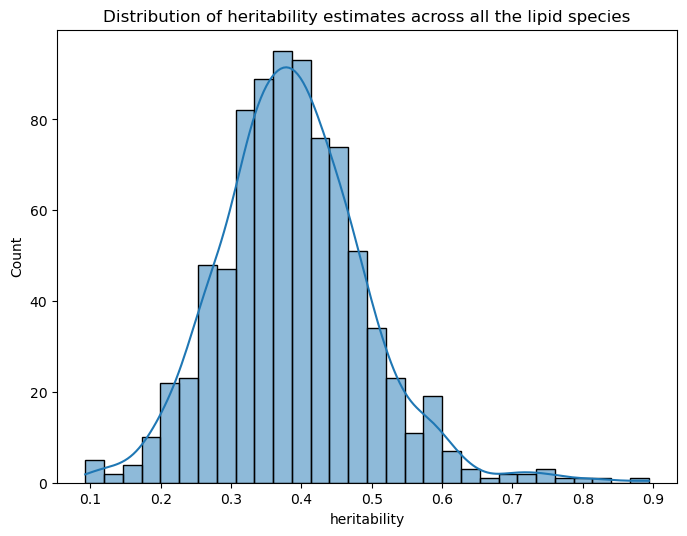

In [14]:
# Plot distribution of heritability estimates across all the lipid species
fig_hist, ax_hist = plt.subplots(figsize=(8,6), dpi=100)
sns.histplot(data=df_merged, x="heritability", kde=True, ax=ax_hist)
ax_hist.set_title('Distribution of heritability estimates across all the lipid species')

In [15]:
df_merged

,lipid species,lipid llass,lipid,heritability,SE
687,AC(16:0),AC,AC-16:0-,0.295054,0.069689
767,AC(18:1),AC,AC-18:1-,0.249624,0.066649
437,AC(24:1) (a),AC,AC-24:1-_-a-,0.377007,0.064408
458,AC(24:1) (b),AC,AC-24:1-_-b-,0.371242,0.064857
415,AC(17:0) (a),AC,AC-17:0-_-a-,0.383117,0.063128
...,...,...,...,...,...
111,methyl-CE(18:2),methyl-CE,methyl-CE-18:2-,0.491240,0.062791
722,methyl-CE(22:6),methyl-CE,methyl-CE-22:6-,0.273206,0.065970
10,methyl-CE(20:4),methyl-CE,methyl-CE-20:4-,0.696557,0.052052
268,methyl-DE(18:2),methyl-DE,methyl-DE-18:2-,0.424325,0.063588


## 3. Plot correlations across lipids

In [3]:
# Load lipid species measures
fn_species = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species.txt'
df_lip_species = pd.read_csv(fn_species, sep='\t').drop(columns='MS Label').set_index(keys='Sample ID').T.reset_index().rename(columns={'index':'LIPID'})
print(df_lip_species.shape)
display(df_lip_species.head(2))

# Load phenotype data
cols = ['RRID', 'LABID', 'VISIT', 'INTERVIEW_DATE', 'AGE_AT_VISIT', 'GENDER', 'hdlc', 'ldlcalc', 'CHOL1', 'trig']
df_pheno = pd.read_csv('/data100t1/share/CCHC/phenotypes/0723/cchc_phenotypes_0723.txt', sep='|', dtype=str)[cols]
display(df_pheno.head(2))

(830, 2500)


Sample ID,LIPID,HA0104,BD6685,LD4104,LA0113,BA0207,BA0266,BD6289,BD6405,BL0053,...,HA0102,BA0400,BD6323,LA0040,HD4146,LA0390,BD6169,HD4205,BD6330,LA0396
0,Sph(d18:1),218.972291,438.511461,687.733746,108.991065,894.791885,270.642014,150.308401,282.126982,71.095979,...,235.678005,209.295155,309.370740,70.863494,531.073498,128.349694,666.213858,176.842569,93.238494,166.068091
1,Sph(d18:2),36.027206,77.764685,71.339653,27.579729,119.017911,40.700290,32.240980,45.811927,22.606433,...,34.523479,37.855902,49.016939,16.284717,74.124726,39.070802,135.387642,47.338308,31.914388,53.648802


,RRID,LABID,VISIT,INTERVIEW_DATE,AGE_AT_VISIT,GENDER,hdlc,ldlcalc,CHOL1,trig
0,BD0001,BD4001,1.0,2004-01-29,40.0,2.0,45.0,121.0,189.0,115.0
1,BD0001,5Y0002,2.0,2008-10-08,30.4,2.0,42.0,140.6,212.0,147.0


In [6]:
# Map lipid class to lipid species measures
df_merged_species_class = df_lip_species.merge(df_lipid_mapping, left_on='LIPID', right_on='Lipid Name')
df_merged_species_class.drop(columns=['Lipid Name', 'species', 'class'], inplace=True)
df_merged_species_class

,LIPID,HA0104,BD6685,LD4104,LA0113,BA0207,BA0266,BD6289,BD6405,BL0053,...,BA0400,BD6323,LA0040,HD4146,LA0390,BD6169,HD4205,BD6330,LA0396,Lipid Class
0,Sph(d18:1),218.972291,438.511461,687.733746,108.991065,894.791885,270.642014,150.308401,282.126982,71.095979,...,209.295155,309.370740,70.863494,531.073498,128.349694,666.213858,176.842569,93.238494,166.068091,Sph
1,Sph(d18:2),36.027206,77.764685,71.339653,27.579729,119.017911,40.700290,32.240980,45.811927,22.606433,...,37.855902,49.016939,16.284717,74.124726,39.070802,135.387642,47.338308,31.914388,53.648802,Sph
2,S1P(d16:1),101.913318,101.187911,66.538890,78.535146,137.455357,162.918329,103.043534,110.136913,78.995166,...,83.094441,103.864021,65.039570,101.497609,80.004384,84.367998,149.152709,92.236001,126.566543,S1P
3,S1P(d18:0),131.658287,199.556423,184.142751,68.069746,356.446015,235.710169,250.298867,267.527725,71.934927,...,198.311706,197.300008,38.059896,248.811767,218.983745,222.645992,172.557018,126.868242,166.871647,S1P
4,S1P(d18:1),1153.691330,1398.262469,1380.278040,631.422062,2599.258204,1859.406356,1552.306241,1955.370065,755.460757,...,1286.150566,1601.478155,421.105135,1907.138125,1394.353986,1766.391182,1161.591723,1147.459833,1588.086598,S1P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,LPC(20:4) [+OH],29.764967,83.618501,18.842292,6.555864,39.848874,37.782036,80.965528,31.276236,19.716687,...,40.687633,83.384168,8.034108,72.903384,12.585192,309.023744,16.399742,45.403780,9.398987,OxSpecies
825,LPC(22:6) [+OH],9.233837,29.565119,9.354539,4.047986,9.908459,14.511714,25.186734,6.270417,5.491787,...,16.661735,38.993771,9.002143,28.724246,4.585979,76.070154,7.065979,10.347957,3.916751,OxSpecies
826,PC(34:2) [+OH],8.428339,14.366459,10.134875,15.470145,23.345850,13.883794,12.967532,11.617390,9.548963,...,26.740529,58.559304,40.311465,37.147707,12.576857,21.696032,19.122626,10.656910,15.405158,OxSpecies
827,PC(36:4) [+OH],116.364699,74.550387,73.693686,65.670613,68.125053,98.271177,66.944286,86.947524,53.911451,...,95.704774,132.436597,54.419440,51.213319,50.825512,110.985970,94.383237,106.822737,91.406804,OxSpecies


In [36]:
df_merged_species_class['Lipid Class']

0            Sph
1            Sph
2            S1P
3            S1P
4            S1P
         ...    
824    OxSpecies
825    OxSpecies
826    OxSpecies
827    OxSpecies
828    OxSpecies
Name: Lipid Class, Length: 829, dtype: object

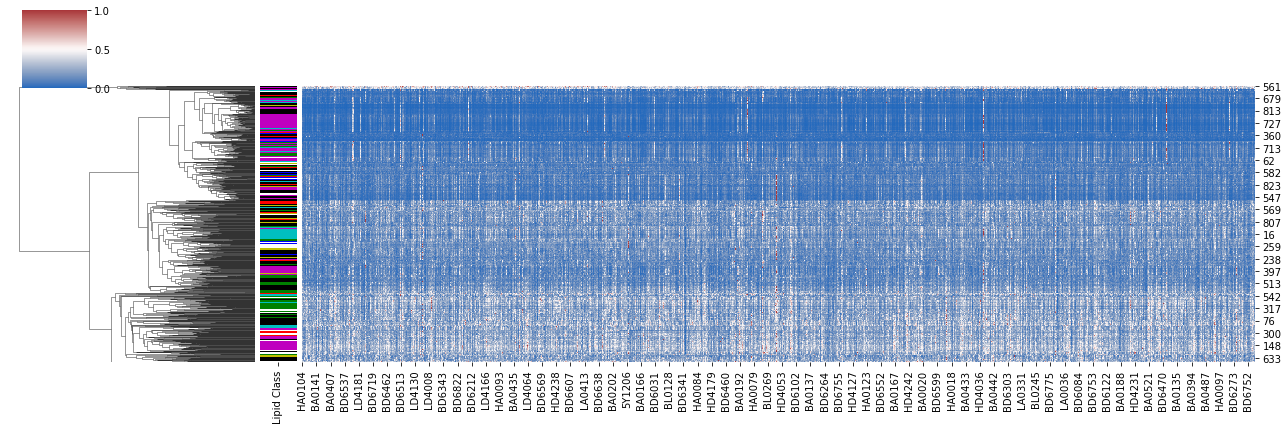

In [37]:
# Plot cluster plot across all the lipid species
# fig_cluster, ax_clulster = plt.subplots(figsize=(10,6), dpi=100)
# row_colors=df_merged_species_class['Lipid Class']
# sns.clustermap(data=df_merged_species_class.iloc[:, 1:-1], figsize=(10, 6),
#                col_cluster=False, metric="correlation")
sns.clustermap(data=df_merged_species_class.iloc[:, 1:-1], figsize=(18, 6),
               col_cluster=False, cmap='vlag', standard_scale=0,
               row_colors=df_merged_species_class['Lipid Class'].map(dict(zip(df_merged_species_class['Lipid Class'].unique(), 'rgbcmykw'*6+'r'))))